# Data Processing - Machine Learning

This jupiter notebook is the second of the two main notebooks for the project. <br>

The goals are to import all the features and then train pattern recognition models on those.

In [1]:
#basic imports
import scipy
import csv
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import seaborn
import warnings
warnings.filterwarnings("ignore")

#The ML imports are done before each section to make it clear which libraries are used for each method

import statistics
import math
import os

### <u> <b> 1. Import data

In [2]:
# Import function:
def import_features(name):
    
    #input: subject nbr, motion nbr, side(r or l)
    #returns: corresponding EMG and IMU files

    #get the directions:
    label_dir = "features/" + name + "_labels.csv" 
    data_dir = "features/" + name + ".csv" 
    
    #get the labels of the features:
    labels = pd.read_csv(label_dir)
    labels = labels.drop(columns=['Unnamed: 0'])
    lab = labels['feature_labels'].tolist()

    #get the data:
    data = pd.read_csv(data_dir)
    data = data.drop(columns=['Unnamed: 0'])
    
    return data,lab

In [3]:
#Import:

name_of_the_feature_file = 'RMS_ZCR_fmean' #define the file of interest

model_number = '3'

data,features = import_features(name_of_the_feature_file)


In [4]:
print(data[0:10])

   subject  motion side  wave   ch1_RMS  ch1_ZCR  ch1_mean_freq   ch2_RMS  \
0        1       1    r     5  0.056529      580     111.384875  0.061948   
1        1       8    l     9  0.044605      637     108.124344  0.058649   
2        1       8    l     8  0.060064      668      95.398184  0.058898   
3        1       1    r     4  0.104085      600     112.549896  0.121531   
4        1       1    r    10  0.027950      578     104.908335  0.031688   
5        1       7    l     1  0.099692      679     134.693579  0.133610   
6        1       6    l     1  0.031089      717     130.947920  0.099429   
7        1       7    l     3  0.059879      679     133.610592  0.091855   
8        1       6    l     3  0.031284      650     125.652451  0.082442   
9        1       3    l     9  0.048119      618     109.739597  0.062061   

   ch2_ZCR  ch2_mean_freq  ...  ch4_mean_freq  x_acc_RMS  x_acc_ZCR  \
0      576     109.038130  ...     113.801608   0.076585        147   
1      642

## <u> <b> 5. MACHINE LEARNING

In [5]:
#imports only used for the ML part:
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.linear_model import RidgeClassifier

In [6]:
def get_acc_from_matrix(matrix):
    
    #input: confusion matrix of any degree
    #returns: entire accuracy
    
    diag = 0
    for k in range(0,len(matrix)):
        diag += matrix[k][k]
        
    all_sum = matrix.sum()
    
    accuracy = diag/all_sum
    
    return accuracy


In [7]:
#confusion matrix and information from it:

def confusion_analysis(matrix): #for each class we want to get the 3 information
    
    #input: confusion matrix
    #output: 4 arrays for accuracies,precisions,recalls,F1s (one value for each motion)
    
    accuracies = []
    precisions = []
    recalls = []
    F1s = []
    
    for k in range(0,len(matrix)):
        
        TP = matrix[k][k] #true positives
        
        FP = sum(matrix[k])-TP #false positives

        FN = sum(matrix[:,k]) - TP #false negatives
        
        TN = matrix.sum() - (TP+FP+FN) #true negatives
        
        
        #now those can be used to calculate the parameters:
        
        a = (TP+TN)/(TP+TN+FP+FN)
        accuracies.append(a)

        p = TP/(TP+FP) #TP/(TP+FP)
        precisions.append(p)
        
        r = TP/(TP+FN) #TP/(TP+FN)
        recalls.append(r)
        
        f = (2*p*r)/(p+r) #(2*p*r)/(p+r)
        F1s.append(f)
        

    
    return accuracies,precisions,recalls,F1s

In [8]:
def plot_conf_features(matrix,method,model_nbr,save=False):

    #input: confusion matrix , name of the method as str
    #returns: dataframe with the features and plots bar charts for each motion for each feature
    
    a,p,r,f = confusion_analysis(matrix)
    
    motions = ['m1','m2','m3','m4','m5','m6','m7','m8']
    
    labels = ['Accuracy','Precision','Recall-rate','F1-rate']
    
    features_all = {'Motion':motions,'Accuracy':a,'Precision':p,'RecallRate': r,'F1Rate':f}
    
    features = pd.DataFrame(features_all)

    fig, axs = plt.subplots(4,figsize=(16,9))
    axs[0].set_title('Analysis of the confusion matrix of the ' + method + ' - Model ' + model_nbr)
    axs[0].bar(features.Motion, features.Accuracy)
    axs[1].bar(features.Motion, features.Precision)
    axs[2].bar(features.Motion, features.RecallRate)
    axs[3].bar(features.Motion, features.F1Rate)
    
    for k in range(0,4):
        axs[k].set_ylabel(labels[k])
        axs[k].set_ylim(0,1)
        axs[k].grid()
    
    if save:
        full_name = "Figures/" + method + "_analysis_mod" + model_nbr + ".png"
        plt.savefig(full_name, dpi=300)
    
    return features

In [9]:
def confusion_heat(matrix,method,model_nbr,save=False):

    #input: confusion matrix and used method
    #returns: confusion matrix as heat map
    
    labels = np.linspace(1,len(matrix),len(matrix),dtype=int)
    plt.figure(figsize = (8,6))
    s = seaborn.heatmap(matrix,xticklabels=labels,yticklabels=labels,annot=True)
    s.set_xlabel('True Class (motion)')
    s.set_ylabel('Predicted Class (motion)')
    plt.title('Confusion Matrix for ' + method + ' - Model ' + model_nbr)
    if save:
        full_name = "Figures/" + method + "_conf_mod" + model_nbr + ".png"
        plt.savefig(full_name, dpi=300)
    plt.show()
      

### <b> Split and Standardise the data

In [10]:
#features

In [11]:
#First split the data into randomized training set and test set (70-30% split):
data_train, data_test = train_test_split(data, test_size=0.3, train_size=0.7, random_state=4) #70% of training and 30% for testing

#features = features  #features
labels = ["motion"] #name of the column storing the motion

#Standardize the data
data_training_scaled = StandardScaler().fit_transform(data_train[features]) #for the training data
data_training_labels = data_train[labels] #so the labels from the dataset for training

data_test_scaled = StandardScaler().fit_transform(data_test[features]) #for the test data
data_test_labels = data_test[labels] #so the labels from the dataset for testing

## <u> <b> Method 1: k-NN <br>
    
Several values of k should be tested in order to decide the most fitting value for k for the kNN method. So it was decided to try values of $k = 1,2,..,50$

Accuracies of the kNN-method for each value of k: [0.59375, 0.5364583333333334, 0.5625, 0.578125, 0.59375, 0.5833333333333334, 0.59375, 0.6041666666666666, 0.6197916666666666, 0.609375, 0.6145833333333334, 0.5989583333333334, 0.6041666666666666, 0.5885416666666666, 0.59375, 0.6145833333333334, 0.6041666666666666, 0.6197916666666666, 0.59375, 0.59375, 0.5833333333333334, 0.5833333333333334, 0.5885416666666666, 0.5416666666666666, 0.546875, 0.5572916666666666, 0.5677083333333334, 0.5572916666666666, 0.5625, 0.546875, 0.53125, 0.5260416666666666, 0.4895833333333333, 0.4947916666666667, 0.5, 0.5, 0.515625, 0.515625, 0.5052083333333334, 0.5, 0.5, 0.5104166666666666, 0.4895833333333333, 0.4791666666666667, 0.484375, 0.484375, 0.5, 0.4791666666666667, 0.453125, 0.4479166666666667]
The optimal value for k is:  9


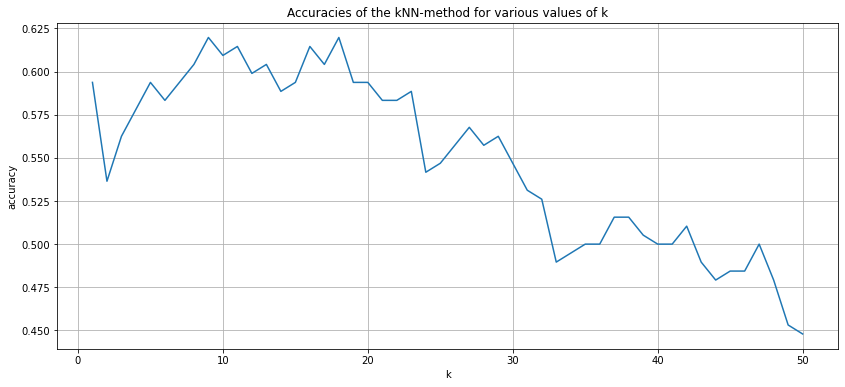

In [12]:
kNN_models = [0] * 50 #create a list with 50 entries in which the 50 models with k=1..50 will be saved
kNN_accuracies = [0] * 50 #create another list with 50 entries to save each accuracy

k_values=range(1,51)
for k in k_values:
    #create and train a kNN-model:
    kNN_models[k-1] = KNeighborsClassifier(n_neighbors=k) #create the model with the k value
    kNN_models[k-1].fit(data_training_scaled,np.ravel(data_training_labels)) #training the defined kNN-Model
    
    #obtain its accuracy
    #method 1: cross-validation
    #kNN_accuracies[k-1] = np.mean(cross_val_score(kNN_models[k-1],data_test_scaled,np.ravel(data_test_labels),cv=LeaveOneOut())) 
    #method 2: simply getting the accuracy
    simu_at_k = kNN_models[k-1].predict(data_test_scaled)
    matrix_at_k = metrics.confusion_matrix(data_test_labels, simu_at_k)
    kNN_accuracies[k-1] = get_acc_from_matrix(matrix_at_k)
    

    
print("Accuracies of the kNN-method for each value of k:",kNN_accuracies) #print the list of accuracies to visu
optimal_k = kNN_accuracies.index(max(kNN_accuracies)) + 1  #determine the optimal value for k
print("The optimal value for k is: ",optimal_k) #and print that optimal value


s = True  #SAVE?

plt.figure(figsize=(14,6))
plt.grid()
plt.plot(k_values,kNN_accuracies)
plt.xlabel("k")
plt.ylabel("accuracy")
plt.title("Accuracies of the kNN-method for various values of k")
if s:
    full_name = "Figures/" + "k_values_Mod" + model_number + ".png"
    plt.savefig(full_name, dpi=300)
plt.show()



In [13]:
#Best k-value:
best_k = optimal_k

#Use the imported function KNeighborsClassifier (https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
kNN_model = KNeighborsClassifier(n_neighbors=best_k) #with the best k-value found just before
kNN_model.fit(data_training_scaled,np.ravel(data_training_labels)) #training the kNN-Model
#according to the warning received from python using the np.ravel() function allows to indicate that the row has to be used as an array


#then compute the confusion matrix:

#so first predict from the test features:
simulated_kNN_labels = kNN_model.predict(data_test_scaled)

#and then the confusion matrix can be obtained:
matrix_kNN = metrics.confusion_matrix(data_test_labels, simulated_kNN_labels) 


print("Confusion matrix of the kNN-method:")
print(matrix_kNN)


Confusion matrix of the kNN-method:
[[15  4  1  0  1  0  0  3]
 [ 3 17  1  3  1  0  1  0]
 [ 3  2  7  1  0  0  0 10]
 [ 0  4  1 20  0  0  0  0]
 [ 0  3  0  0 25  1  0  1]
 [ 0  4  3  0  1 12  2  3]
 [ 1  3  2  0  2  0 13  1]
 [ 1  0  6  0  0  0  0 10]]


In [14]:
kNN_accuracy = get_acc_from_matrix(matrix_kNN)
print(kNN_accuracy)

0.6197916666666666


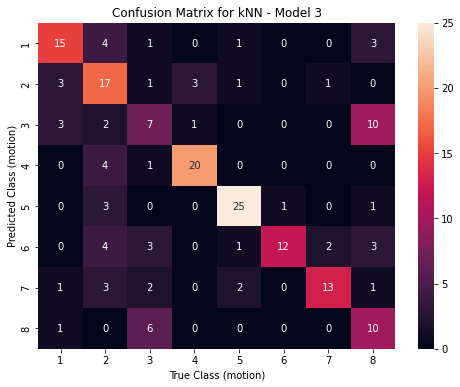

In [15]:
confusion_heat(matrix_kNN,'kNN',model_number,save=True)

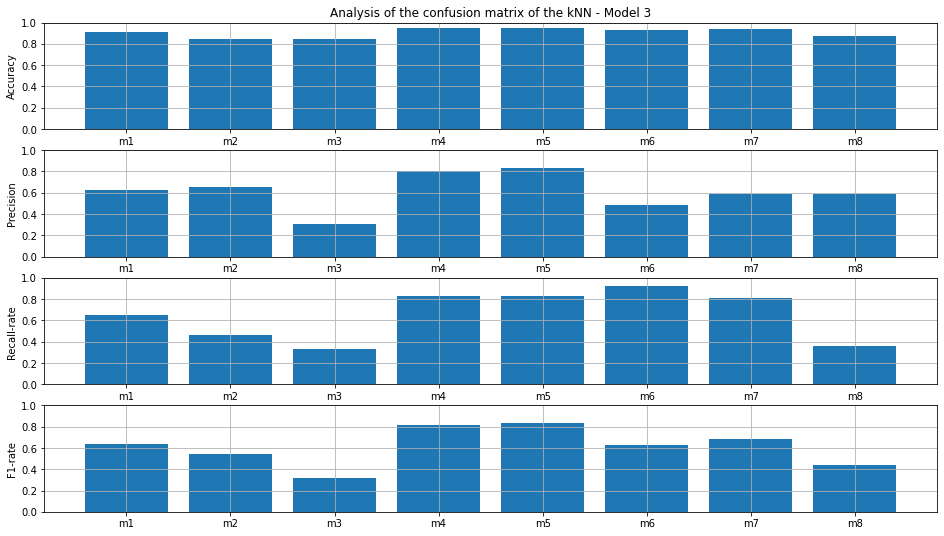

In [16]:
kNN_features = plot_conf_features(matrix_kNN,'kNN',model_number,save=True)

In [17]:
kNN_features

,Motion,Accuracy,Precision,RecallRate,F1Rate
0,m1,0.911458,0.625000,0.652174,0.638298
1,m2,0.848958,0.653846,0.459459,0.539683
2,m3,0.843750,0.304348,0.333333,0.318182
3,m4,0.953125,0.800000,0.833333,0.816327
4,m5,0.947917,0.833333,0.833333,0.833333
5,m6,0.927083,0.480000,0.923077,0.631579
6,m7,0.937500,0.590909,0.812500,0.684211
7,m8,0.869792,0.588235,0.357143,0.444444


## <u> <b> Method 2: Gaussian Naive Bayes <br>


In [18]:
#import
from sklearn.naive_bayes import GaussianNB

In [19]:
#create a model:
GNB = GaussianNB()
GNB.fit(data_training_scaled,np.ravel(data_training_labels))

GaussianNB()

In [20]:
simu_GNB = GNB.predict(data_test_scaled)
matrix_GNB = metrics.confusion_matrix(data_test_labels, simu_GNB)
GNB_accuracy = get_acc_from_matrix(matrix_GNB)

In [21]:
GNB_accuracy

0.5208333333333334

In [22]:
matrix_GNB

array([[14,  2,  0,  1,  4,  0,  0,  3],
       [ 2, 13,  4,  4,  2,  0,  1,  0],
       [ 2,  1,  7,  1,  4,  0,  0,  8],
       [ 0,  8,  4, 13,  0,  0,  0,  0],
       [ 4,  1,  2,  0, 22,  1,  0,  0],
       [ 1,  2,  1,  0,  2,  8,  4,  7],
       [ 1,  1,  2,  1,  4,  2, 11,  0],
       [ 0,  0,  0,  1,  2,  1,  1, 12]])

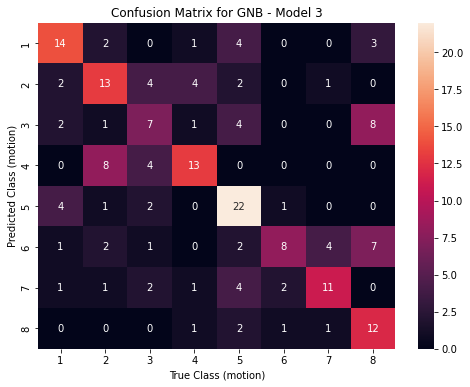

In [23]:
confusion_heat(matrix_GNB,'GNB',model_number,save=True)

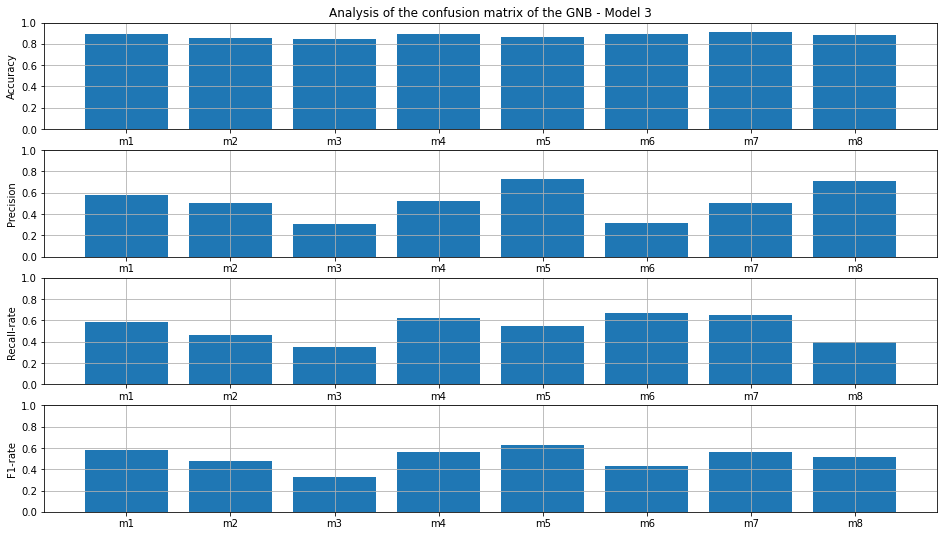

In [24]:
GNB_features = plot_conf_features(matrix_GNB , 'GNB',model_number,save=True)

## <u> <b> Method 3: Logic Regression - One-Vs-Rest (OvR) <br>

The idea is to train 8 classifiers which decide wether it is one class or the rest, so one classifier for each class and then for each 

In [25]:
#import
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import LogisticRegression


In [26]:
# Create a Logistic Regression model
logistic_reg = LogisticRegression()

# Transform it into a OvR using OneVsRestClassifier
OVR = OneVsRestClassifier(logistic_reg)

# Train the model on the data
OVR.fit(data_training_scaled,np.ravel(data_training_labels))


OneVsRestClassifier(estimator=LogisticRegression())

In [27]:
simu_OVR = OVR.predict(data_test_scaled)
matrix_OVR = metrics.confusion_matrix(data_test_labels, simu_OVR)
OVR_accuracy = get_acc_from_matrix(matrix_OVR)

In [28]:
OVR_accuracy

0.7083333333333334

In [29]:
matrix_OVR

array([[16,  3,  2,  1,  1,  0,  0,  1],
       [ 3, 15,  0,  5,  1,  1,  0,  1],
       [ 3,  2,  9,  1,  0,  0,  0,  8],
       [ 0,  3,  0, 21,  0,  1,  0,  0],
       [ 0,  0,  2,  1, 26,  0,  1,  0],
       [ 0,  1,  1,  0,  0, 19,  0,  4],
       [ 0,  0,  1,  0,  1,  2, 18,  0],
       [ 0,  0,  3,  0,  0,  1,  1, 12]])

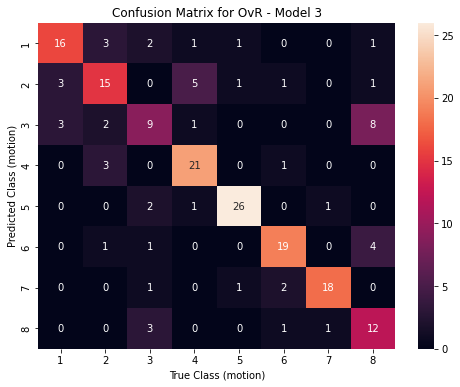

In [30]:
confusion_heat(matrix_OVR,'OvR',model_number,save=True)

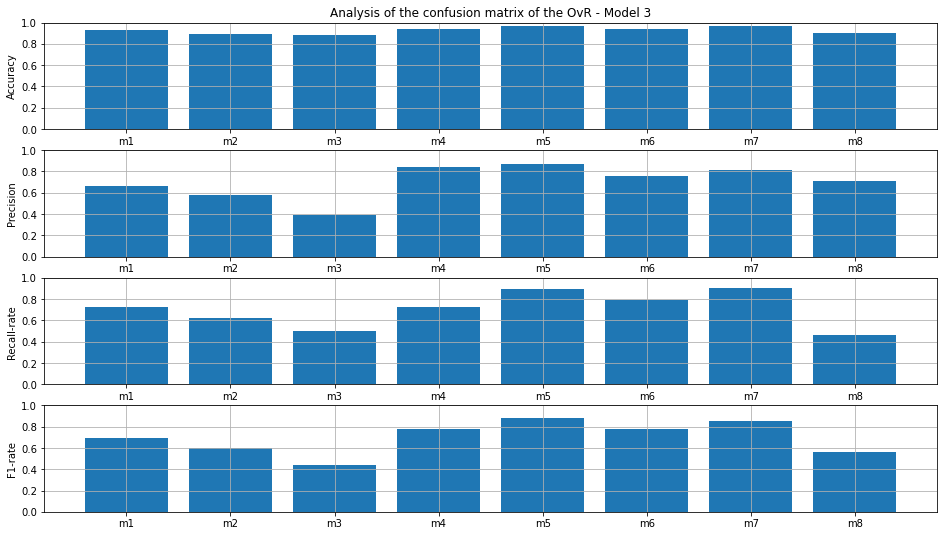

In [31]:
OVR_features = plot_conf_features(matrix_OVR, 'OvR',model_number,save=True)

## <u> <b> Method 4: Logic Regression - One-Vs-One (OvO) <br>

Compared to OvR, the OvO tries every 1v1 combination for all the possible combinations for each element. So for 8 classes, one would train 8×7/2=28 binary classifiers, and each would have the score for each 1v1, and in the end the classifier takes the best score to predict to which class is the one with the most wins.

In [32]:
#import

from sklearn.multiclass import OneVsOneClassifier
from sklearn.linear_model import LogisticRegression

In [33]:
# Create a Logistic Regression model
logistic_reg = LogisticRegression()

# Wrap it with OneVsOneClassifier
OVO = OneVsOneClassifier(logistic_reg)

# Train the model on your data
OVO.fit(data_training_scaled,np.ravel(data_training_labels))

OneVsOneClassifier(estimator=LogisticRegression())

In [34]:
simu_OVO = OVO.predict(data_test_scaled)
matrix_OVO = metrics.confusion_matrix(data_test_labels, simu_OVO)
OVO_accuracy = get_acc_from_matrix(matrix_OVO)

In [35]:
OVO_accuracy

0.7447916666666666

In [36]:
matrix_OVO

array([[19,  1,  1,  1,  1,  0,  0,  1],
       [ 2, 17,  2,  3,  0,  0,  0,  2],
       [ 1,  1, 13,  1,  1,  0,  0,  6],
       [ 0,  4,  0, 21,  0,  0,  0,  0],
       [ 1,  1,  2,  0, 24,  0,  2,  0],
       [ 0,  1,  1,  0,  0, 19,  0,  4],
       [ 0,  1,  0,  0,  2,  2, 16,  1],
       [ 0,  1,  2,  0,  0,  0,  0, 14]])

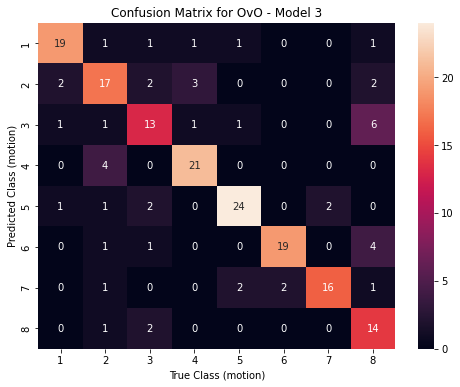

In [37]:
confusion_heat(matrix_OVO,'OvO',model_number,save=True)

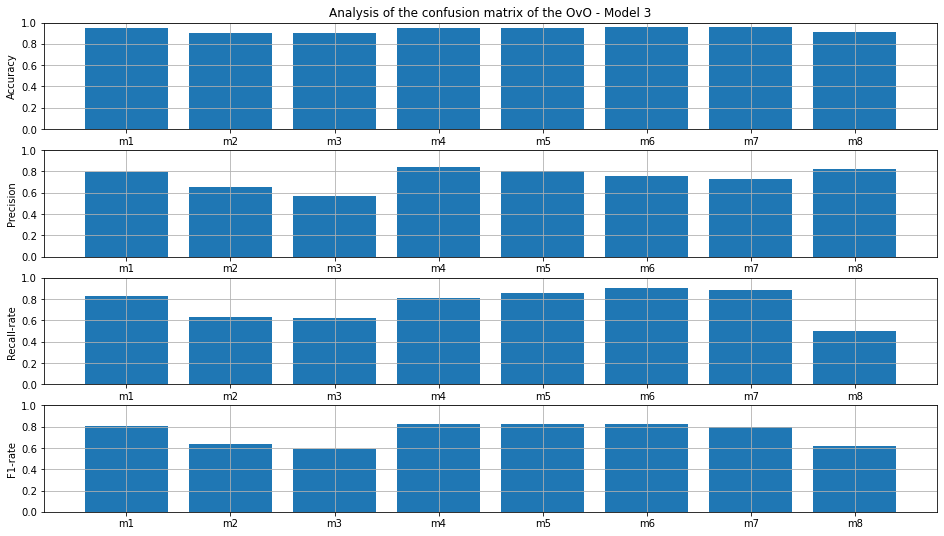

In [38]:
OVO_features = plot_conf_features(matrix_OVO , 'OvO',model_number,save=True)

## <u> <b> Method 5: Random Forest <br>

This approach builds multiple decision trees and merges their predictions. It's known to be robust and can handle multi-class classification very well.

In [39]:
#import
from sklearn.ensemble import RandomForestClassifier

In [40]:
RF = RandomForestClassifier() #create a new random forest classifier
RF.fit(data_training_scaled,np.ravel(data_training_labels)) #and train it

RandomForestClassifier()

In [41]:
simu_RF = RF.predict(data_test_scaled)
matrix_RF = metrics.confusion_matrix(data_test_labels, simu_RF)
RF_accuracy = get_acc_from_matrix(matrix_RF)

In [42]:
RF_accuracy

0.7239583333333334

In [43]:
matrix_RF

array([[19,  1,  0,  1,  0,  0,  0,  3],
       [ 1, 15,  0,  6,  0,  3,  0,  1],
       [ 1,  1, 14,  2,  1,  0,  0,  4],
       [ 0,  4,  0, 21,  0,  0,  0,  0],
       [ 2,  0,  1,  0, 23,  0,  3,  1],
       [ 1,  3,  3,  0,  0, 15,  1,  2],
       [ 1,  0,  0,  0,  0,  1, 20,  0],
       [ 4,  0,  0,  1,  0,  0,  0, 12]])

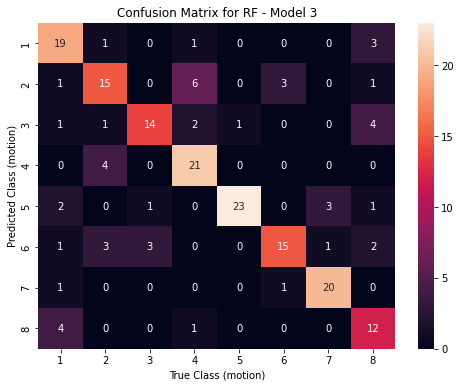

In [44]:
confusion_heat(matrix_RF,'RF',model_number,save=True)

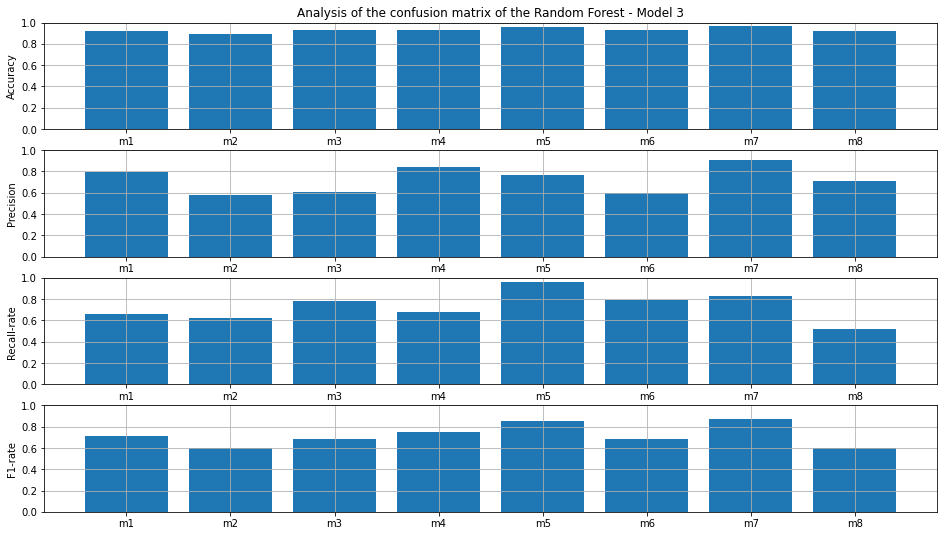

In [45]:
RF_features = plot_conf_features(matrix_RF , 'Random Forest',model_number,save=True)

## <u> <b> Method 6: Neural Network <br>


In [46]:
#ONE-HOT ENCODING:

# Create One-hot encoding for the labels for 8 classes
num_classes = 8
one_hot_labels = np.eye(num_classes)

# Implement the one-hot encoding:
training_labels_onehot= []
test_labels_onehot= []


for k in data_training_labels['motion']:
    training_labels_onehot.append(one_hot_labels[int(k)-1])
    
for k in data_test_labels['motion']:
    test_labels_onehot.append(one_hot_labels[int(k)-1])
    

In [47]:
# Functions:

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def sigmoid_derivative(x):
    return x * (1 - x)


## <u> 1 Hidden Layer

In [48]:
def NeuralNetwork(epoch):
    
    #input: epoch (number of passes)
    #returns: weights of NN
    
    
    # Obtain the size of the weight matrix:
    x_weight = len(data_training_scaled[0])  # number of inputs (features)
    y_weight = 8  # number of neurons in the hidden layer

    # Initialize weights with random values
    weights = 2 * np.random.random((x_weight, y_weight)) - 1

    # Training the neural network
    epochs = epoch  # how many passes
    learning_rate = 0.1

    for epoch in range(epochs):
        for i in range(len(data_training_scaled)):
            # Forward pass for a single sample
            input_sample = data_training_scaled[i]
            hidden_output = sigmoid(np.dot(input_sample, weights))

            # Calculate the error for a single sample
            error = training_labels_onehot[i] - hidden_output

            # Backpropagation for a single sample
            adjustments = error * sigmoid_derivative(hidden_output)
            weights += learning_rate * np.outer(input_sample, adjustments)
            
    return weights


In [49]:
def NN_test_paramters(start,end):
    
    NN_accuracies = [] #create another list with 50 entries to save each accuracy
    p_values = []

    for k in range(int(start/100),int(end/100)+1): # +1 so that it actually goes to the last desired epoch

        ep = k*100 #define epoch
        p_values.append(ep)

        w_at_k = NeuralNetwork(k) #train a neural network

        #test it
        test_predictions = sigmoid(np.dot(data_test_scaled, w_at_k))

        # Convert the predictions to class labels
        predicted_labels = np.argmax(test_predictions, axis=1)
        true_labels = np.argmax(test_labels_onehot, axis=1)

        #obtain accuracy
        matrix_Neural = metrics.confusion_matrix(true_labels, predicted_labels)
        Neural_accuracy = get_acc_from_matrix(matrix_Neural)
        NN_accuracies.append(Neural_accuracy)
        
    print("Accuracies of the NN-method (1 hidden layer) for each value of k:",NN_accuracies) #print the list of accuracies to visualise
    optimal_p = p_values[(NN_accuracies.index(max(NN_accuracies)))]  #determine the optimal value for epoch
    print("The optimal value for epoch is: ",optimal_p) #and print that optimal value

    s_NN1 = True  #SAVE?

    plt.figure(figsize=(14,6))
    plt.grid()
    plt.plot(p_values,NN_accuracies)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracies of the Neural Networks (1 hidden layer) for various values of epoch")
    if s_NN1:
        full_name = "Figures/" + "NN1_epoch_values_Mod" + model_number + ".png"
        plt.savefig(full_name, dpi=300)
    plt.show()

    return optimal_p
    

Accuracies of the NN-method (1 hidden layer) for each value of k: [0.2916666666666667, 0.4322916666666667, 0.453125, 0.5, 0.5572916666666666, 0.5885416666666666, 0.5520833333333334, 0.609375, 0.5520833333333334, 0.609375, 0.5677083333333334, 0.5833333333333334, 0.5729166666666666, 0.5208333333333334, 0.5572916666666666, 0.5729166666666666, 0.5625, 0.5520833333333334, 0.5520833333333334, 0.5677083333333334, 0.546875, 0.5572916666666666, 0.546875, 0.5208333333333334, 0.5572916666666666, 0.5364583333333334, 0.5364583333333334, 0.5208333333333334, 0.5729166666666666, 0.5572916666666666, 0.5833333333333334, 0.5572916666666666, 0.5833333333333334, 0.546875, 0.5625, 0.5364583333333334, 0.5520833333333334, 0.5729166666666666, 0.5364583333333334, 0.5625, 0.5364583333333334, 0.5572916666666666, 0.5729166666666666, 0.5572916666666666, 0.546875, 0.5677083333333334, 0.546875, 0.5625, 0.5572916666666666, 0.546875]
The optimal value for epoch is:  800


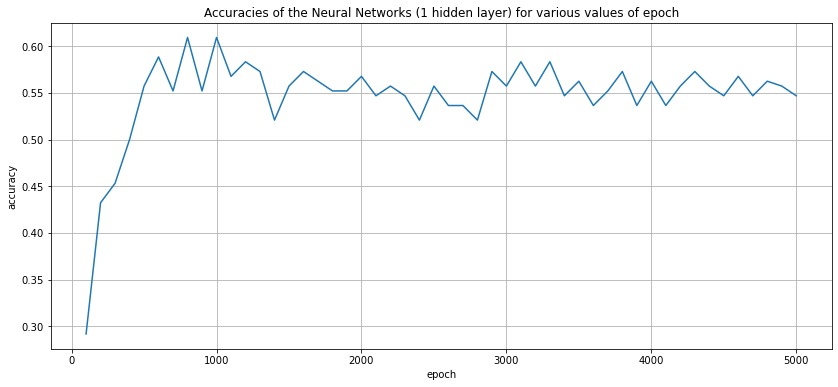

In [50]:
optimal_p = NN_test_paramters(100,5000)

In [51]:
# Test the neural network on the test set
weights = NeuralNetwork(optimal_p)
test_predictions = sigmoid(np.dot(data_test_scaled, weights))

# Convert the predictions to class labels
predicted_labels = np.argmax(test_predictions, axis=1)
true_labels = np.argmax(test_labels_onehot, axis=1)

In [52]:
matrix_Neural = metrics.confusion_matrix(true_labels, predicted_labels)
Neural_accuracy = get_acc_from_matrix(matrix_Neural)

In [53]:
Neural_accuracy

0.5833333333333334

In [54]:
matrix_Neural

array([[ 9,  3,  5,  1,  1,  0,  0,  5],
       [ 2,  9,  4, 10,  0,  1,  0,  0],
       [ 3,  1, 15,  0,  0,  0,  0,  4],
       [ 0,  4,  6, 14,  0,  1,  0,  0],
       [ 1,  0,  0,  3, 23,  0,  2,  1],
       [ 0,  0,  1,  5,  0, 15,  0,  4],
       [ 0,  0,  0,  0,  1,  3, 18,  0],
       [ 0,  0,  6,  0,  1,  0,  1,  9]])

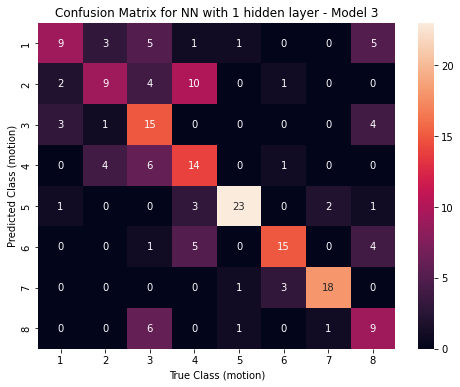

In [55]:
confusion_heat(matrix_Neural,'NN with 1 hidden layer',model_number,save=True)

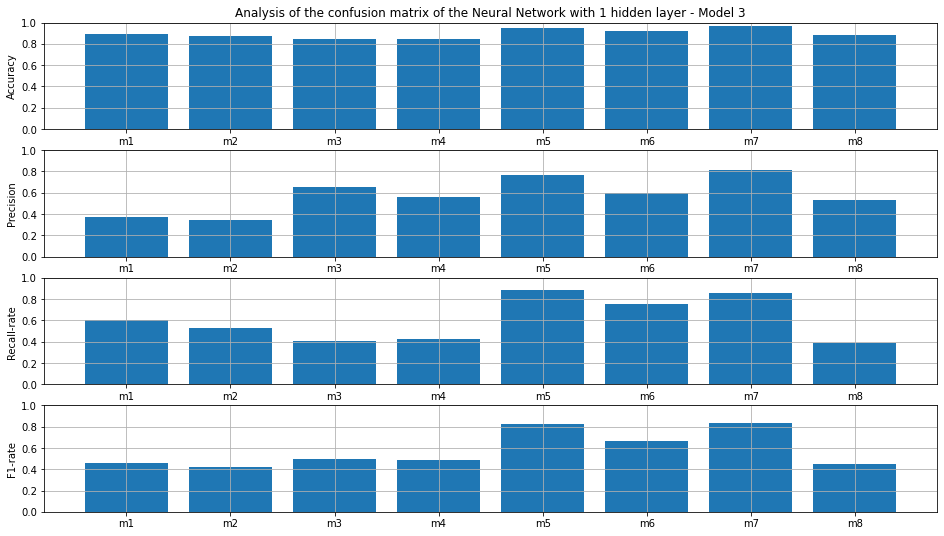

In [56]:
Neural_features = plot_conf_features(matrix_Neural , 'Neural Network with 1 hidden layer',model_number,save=True)

## <u> 2 Hidden Layer

In [57]:
def NeuralNetwork_2Layers(epoch):
    
    # Obtain the size of the weight matrices:
    input_size = len(data_training_scaled[0])  # number of inputs (features)
    hidden1_size = 8  # number of neurons in the first hidden layer (different kind of motions)
    hidden2_size = 8  # number of neurons in the second hidden layer
    output_size = 8  # number of neurons in the output layer

    # Initialize weights with random values
    weights_input_hidden1 = 2 * np.random.random((input_size, hidden1_size)) - 1
    weights_hidden1_hidden2 = 2 * np.random.random((hidden1_size, hidden2_size)) - 1
    weights_hidden2_output = 2 * np.random.random((hidden2_size, output_size)) - 1

    # Training the neural network
    epochs = epoch  # how many passes
    learning_rate = 0.1

    for ep in range(epochs):
        for i in range(len(data_training_scaled)):
            # Forward pass for a single sample
            input_sample = data_training_scaled[i]

            # First hidden layer
            hidden1_output = sigmoid(np.dot(input_sample, weights_input_hidden1))

            # Second hidden layer
            hidden2_output = sigmoid(np.dot(hidden1_output, weights_hidden1_hidden2))

            # Output layer
            output = sigmoid(np.dot(hidden2_output, weights_hidden2_output))

            # Calculate the error for a single sample
            error = training_labels_onehot[i] - output

            # Backpropagation for a single sample

            # Output layer adjustments
            adjustments_output = error * sigmoid_derivative(output)
            weights_hidden2_output += learning_rate * np.outer(hidden2_output, adjustments_output)

            # Second hidden layer adjustments
            adjustments_hidden2 = np.dot(adjustments_output, weights_hidden2_output.T) * sigmoid_derivative(hidden2_output)
            weights_hidden1_hidden2 += learning_rate * np.outer(hidden1_output, adjustments_hidden2)

            # First hidden layer adjustments
            adjustments_hidden1 = np.dot(adjustments_hidden2, weights_hidden1_hidden2.T) * sigmoid_derivative(hidden1_output)
            weights_input_hidden1 += learning_rate * np.outer(input_sample, adjustments_hidden1)

    return weights_input_hidden1, weights_hidden1_hidden2, weights_hidden2_output


In [58]:
def NN_test_paramters_2lay(start,end):
    
    NN_accuracies_2lay = [] #create another list with 50 entries to save each accuracy
    p_values_2lay = []

    for k in range(int(start/100),int(end/100)+1): # +1 so that it actually goes to the last desired epoch

        ep = k*100 #define epoch
        p_values_2lay.append(ep)

        # Train the neural network
        trained_weights = NeuralNetwork_2Layers(ep)

        # Unpack the weights
        weights_input_hidden1, weights_hidden1_hidden2, weights_hidden2_output = trained_weights

        # Forward pass on the test set
        hidden1_output = sigmoid(np.dot(data_test_scaled, weights_input_hidden1))
        hidden2_output = sigmoid(np.dot(hidden1_output, weights_hidden1_hidden2))
        test_predictions_2lay = sigmoid(np.dot(hidden2_output, weights_hidden2_output))

        # Convert the predictions to class labels
        predicted_labels_2lay = np.argmax(test_predictions_2lay, axis=1)
        true_labels_2lay = np.argmax(test_labels_onehot, axis=1)

        #obtain accuracy
        matrix_Neural_2lay = metrics.confusion_matrix(true_labels_2lay, predicted_labels_2lay)
        Neural_accuracy_2lay = get_acc_from_matrix(matrix_Neural_2lay)
        NN_accuracies_2lay.append(Neural_accuracy_2lay)
        
    print("Accuracies of the NN-method (2 hidden layer) for each value of k:",NN_accuracies_2lay) #print the list of accuracies to visualise
    optimal_p_2lay = p_values_2lay[(NN_accuracies_2lay.index(max(NN_accuracies_2lay)))]  #determine the optimal value for epoch
    print("The optimal value for epoch is: ",optimal_p_2lay) #and print that optimal value

    
    plt.figure(figsize=(10,6))
    plt.grid()
    plt.plot(p_values_2lay,NN_accuracies_2lay)
    plt.xlabel("epoch")
    plt.ylabel("accuracy")
    plt.title("Accuracies of the Neural Networks (2 hidden layer) for various values of epoch")
    plt.show()
    
    return optimal_p_2lay
  

In [59]:
#optimal_ep_2lay = NN_test_paramters_2lay(100,1000)

In [60]:
# Train the neural network
trained_weights = NeuralNetwork_2Layers(1000)

# Unpack the weights
weights_input_hidden1, weights_hidden1_hidden2, weights_hidden2_output = trained_weights

# Forward pass on the test set
hidden1_output = sigmoid(np.dot(data_test_scaled, weights_input_hidden1))
hidden2_output = sigmoid(np.dot(hidden1_output, weights_hidden1_hidden2))
test_predictions_2lay = sigmoid(np.dot(hidden2_output, weights_hidden2_output))

# Convert the predictions to class labels
predicted_labels_2lay = np.argmax(test_predictions_2lay, axis=1)
true_labels_2lay = np.argmax(test_labels_onehot, axis=1)

In [61]:
matrix_Neural_2lay = metrics.confusion_matrix(true_labels_2lay, predicted_labels_2lay)
Neural_accuracy_2lay = get_acc_from_matrix(matrix_Neural_2lay)

In [62]:
Neural_accuracy_2lay

0.65625

In [63]:
matrix_Neural_2lay

array([[17,  3,  1,  1,  0,  0,  0,  2],
       [ 3, 12,  7,  1,  0,  1,  0,  2],
       [ 3,  1,  9,  3,  0,  3,  0,  4],
       [ 0,  2,  2, 19,  0,  0,  1,  1],
       [ 2,  2,  0,  0, 20,  0,  6,  0],
       [ 0,  0,  0,  1,  0, 21,  3,  0],
       [ 0,  0,  0,  0,  0,  3, 18,  1],
       [ 1,  0,  2,  1,  0,  3,  0, 10]])

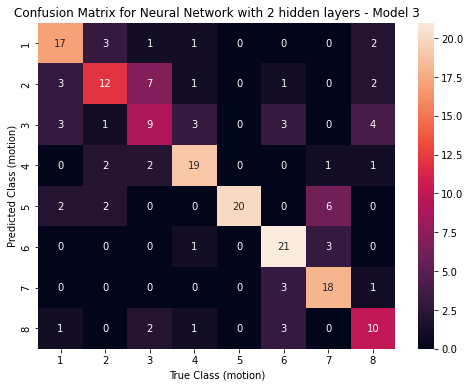

In [64]:
confusion_heat(matrix_Neural_2lay,'Neural Network with 2 hidden layers',model_number,save=True)

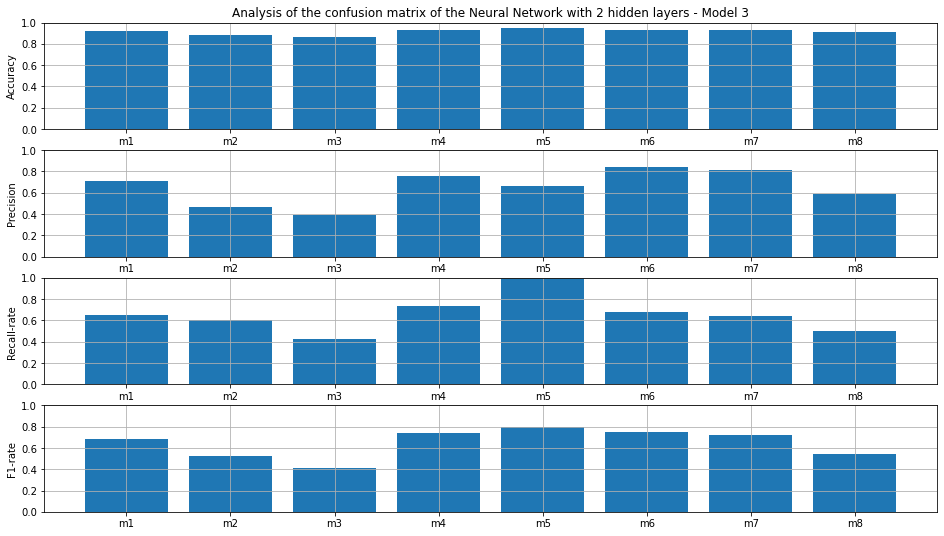

In [65]:
Neural_features = plot_conf_features(matrix_Neural_2lay , 'Neural Network with 2 hidden layers',model_number,save=True)